In [1]:
#%brew install tesseract poppler
%pip install -q "unstructured[all-docs]"

from unstructured.partition.pdf import partition_pdf


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from unstructured.partition.pdf import partition_pdf

elements = partition_pdf(
    filename="TAGIV.pdf", # mandatory
    strategy="hi_res",                                     # mandatory to use ``hi_res`` strategy
    extract_images_in_pdf=True,                            # mandatory to set as ``True``
    extract_image_block_types=["Image", "Table"],          # optional
    extract_image_block_to_payload=False,                  # optional
    extract_image_block_output_dir="saved_images",  # optional - only works when ``extract_image_block_to_payload=False``
    )

In [3]:
from typing import Any

# different category in the document
category_counts = {}

for element in elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1
    
# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts   

{"<class 'unstructured.documents.elements.Header'>": 26,
 "<class 'unstructured.documents.elements.Title'>": 33,
 "<class 'unstructured.documents.elements.NarrativeText'>": 100,
 "<class 'unstructured.documents.elements.Footer'>": 3,
 "<class 'unstructured.documents.elements.Text'>": 18,
 "<class 'unstructured.documents.elements.Formula'>": 42,
 "<class 'unstructured.documents.elements.Image'>": 14,
 "<class 'unstructured.documents.elements.FigureCaption'>": 17,
 "<class 'unstructured.documents.elements.Table'>": 4,
 "<class 'unstructured.documents.elements.ListItem'>": 40}

In [4]:
%pip install -q langchain langchain-chroma unstructured[all-docs] pydantic lxml langchainhub


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [62]:
from unstructured.chunking.basic import chunk_elements
from unstructured.chunking.title import chunk_by_title # might be better for an article ?
from typing import Any

chunks = chunk_by_title(elements)

# different category in the document
category_counts = {}

for element in chunks:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1
    
# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts   

{"<class 'unstructured.documents.elements.CompositeElement'>": 200,
 "<class 'unstructured.documents.elements.Table'>": 3,
 "<class 'unstructured.documents.elements.TableChunk'>": 2}

In [63]:
from pydantic import BaseModel

class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in chunks:
    if "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))
    elif "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]

# Table
table_elements = [e for e in categorized_elements if e.type == "table"]


In [7]:
%pip install -q langchain-openai


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [64]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

## Retriever

# Prompt
prompt_text = """You are an expert Research Assistant tasked with summarizing tables and texts from research articles. \ 
Give a concise summary of the text. text chunk: {element} """

prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4o")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [65]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [114]:
print(text_summaries)

["In their 2023 article published in Neurocomputing, Deka, Nguyen, and Goulet present a method for analytically tractable heteroscedastic uncertainty quantification in Bayesian neural networks (BNNs) specifically for regression tasks. The authors address the challenge of modeling varying levels of uncertainty in data (heteroscedasticity) and propose a solution that enhances the interpretability and reliability of BNNs in predicting outcomes with varying uncertainty levels. The study's findings contribute to the field by providing a more robust framework for uncertainty quantification in regression models.", 'The paper titled "Analytically Tractable Heteroscedastic Uncertainty Quantification in Bayesian Neural Networks for Regression Tasks" is authored by Bhargob Deka, Luong Ha Nguyen, and James-A. Goulet from the Department of Civil, Geologic, and Mining Engineering at Polytechnique Montreal, Canada. The research focuses on developing methods for quantifying uncertainty in Bayesian Neu

In [66]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [115]:
print(table_summaries)

['The text appears to present a series of numerical results, likely from a research study involving different datasets or variables. The datasets or variables mentioned include "Elevators," "KeggD," "KeggU," "Pol," and "Skillcraft." Each dataset or variable is associated with a set of values, possibly representing statistical measures such as means and standard deviations. For example, "Elevators" has values like −0.319 ± 0.027 and 1.012 ± 0.154, while "Skillcraft" has values like −0.981 ± 0.031 and 0.103 ± 0.035. Additionally, "log-likelihood" values are provided for some datasets, such as "KeggD" with 0.602 ± 0.224 and "KeggU" with 3.900 ± 6.003. The context suggests these values are likely used to compare or analyze the performance or characteristics of the datasets or models involved in the study.', 'The text appears to list various datasets (Boston, Concrete, Energy, Kin8nm, Naval, Power, Protein, Wine, Yacht) along with associated parameters (α, β) and numerical values. The param

In [67]:
## getting image summaries
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
    

def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4o", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


fpath = "saved_images"

# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)



In [12]:
image_summaries

['Comparison plots of machine learning models showing log-likelihood and RMSE against time in seconds for Boston, Energy, and Yacht datasets. Models include PCA+ESS, PCA+VI, MC-dropout, PBP-MV, SWAG, TAGI-V, TAGI-V 2L, TAGI, PBP, VMG, Ensemble, DVI, and NN.',
 'Nine line graphs comparing "He" and "Modified He" initialization methods across different datasets (Boston, Concrete, Energy, Kin8nm, Naval, Power, Protein, Wine, Yacht) with log-likelihood plotted against epochs.',
 'Grid of nine line graphs comparing RMSE over epochs for "He" (black) and "Modified He" (red) across different datasets: Boston, Concrete, Energy, Kin8nm, Naval, Power, Protein, Wine, Yacht.',
 'Nine graphs showing Log-likelihood vs. Epoch for different datasets: Boston, Concrete, Wine, Energy, Kin8nm, Naval, Power, Protein, and Yacht. Each graph has a red line representing the log-likelihood trend and a vertical dotted line indicating a specific epoch.',
 'Nine-panel grid comparing log-likelihood vs. epoch for vari

In [74]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images):
    """
    Create retriever that indexes summaries, but returns raw images, table, or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
        search_kwargs={"k": 2}  # Limit to top 5 results
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever



In [75]:
# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_tagiv_paper", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [34]:
## check relevant documents from this retriever

retriever_multi_vector_img.invoke("How is the performance of TAGI-V for the Boston dataset compared to the other methods?")

['TAGI-V are averaged over 3 random seeds. The test log-likelihood values show that TAGI-V performs better than all other methods in 4 out of the 5 datasets. The TAGI-V method is also competitive for RMSE values where it provides the best results in 2 out of the 5 datasets, i.e., Elevators and KeggD, while it is second best for KeggU and Pol. Both PCA+ VI and NL outperform the others in two datasets.']

In [79]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnableParallel
from PIL import Image
from langchain.memory import ConversationBufferMemory


def plt_img_base64(img_base64):
    """Display base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpg;base64,{image}"},
            }
            messages.append(image_message)
            
    # Format chat history
    chat_history = data_dict.get("chat_history", [])
    formatted_chat_history = "\n".join([f"{m.type}: {m.content}" for m in chat_history])

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are a Research Assistant tasked with answering questions on research articles.\n"
            "You will be given a mixed of text, tables, and image(s) usually of tables, charts or graphs.\n"
            "Use this information to provide accurate information related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
            "Chat History:\n"
            f"{formatted_chat_history}\n\n"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]



def multi_modal_rag_chain(retriever, memory=None):
    """
    Multi-modal RAG chain
    """
    if memory is None:
        memory = ConversationBufferMemory(return_messages=True, memory_key="chat_history")
    
    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

    # RAG pipeline
    chain = (
        RunnableParallel(
            {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
            "chat_history": lambda x: memory.load_memory_variables({})["chat_history"]
        })
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    def run_chain(query):
        result = chain.invoke(query)
        memory.save_context({"input": query}, {"output": result})
        return result

    return run_chain



In [80]:
# Create RAG chain
chain_mm_rag = multi_modal_rag_chain(retriever=retriever_multi_vector_img)

In [81]:
# First Question
query = "How is the performance of TAGI-V for the Boston dataset compared to the other methods?"
print(chain_mm_rag(query))

To determine the performance of TAGI-V for the Boston dataset compared to other methods, we need to look at the specific metrics provided for this dataset. The text mentions that TAGI-V performs better than all other methods in 4 out of the 5 datasets for test log-likelihood values and is competitive for RMSE values, providing the best results in 2 out of the 5 datasets.

However, the text does not explicitly state the performance of TAGI-V on the Boston dataset. To provide a precise answer, we would need the specific test log-likelihood and RMSE values for the Boston dataset for TAGI-V and the other methods.

Given the information provided:
- TAGI-V is generally strong in test log-likelihood values.
- TAGI-V is competitive in RMSE values, being the best in some datasets and second best in others.

If the Boston dataset is one of the datasets where TAGI-V is not the best, it might be outperformed by PCA+VI or NL, which are mentioned as top performers in two datasets each.

Without the 

In [90]:

demo = gr.Interface(
    fn=generate,
    inputs=gr.Textbox(label="Query"),
    outputs=gr.Textbox(label="Response"),
    title="chat with TAGI-V",
    allow_flagging='never'
)

# Launch the demo
demo.launch()


Exception in thread Thread-467 (run):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/uvicorn/server.py", line 65, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/nest_asyncio.py", line 26, in run
    loop = asyncio.get_event_loop()
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/nest_

KeyboardInterrupt: 

In [20]:
# Second Question
query = "What is the performance of the same method for the Concrete dataset compared to the other methods?"
print(chain_mm_rag(query))

To assess the performance of the same method for the Concrete dataset compared to other methods, we can refer to the provided graphs and tables. Here is a detailed analysis:

### Performance Metrics:
1. **RMSE (Root Mean Square Error)**:
   - The RMSE values for the Concrete dataset are depicted in the graphs. The methods compared include PCA+ESS, PCA+VI, SWAG, TAGI-V, TAGI-V2L, TAGI, PBP, MC-dropout, PBP-MV, VMG, Ensemble, DVI, and NN.
   - From the graph, it appears that TAGI-V and its variants (TAGI-V2L, TAGI) have competitive RMSE values compared to other methods. The exact RMSE values are not explicitly provided in the text, but the visual representation indicates that TAGI-V performs well.

2. **Training Time**:
   - The training time for the Concrete dataset is shown in the time (s) vs. RMSE graph.
   - TAGI-V and its variants (TAGI-V2L, TAGI) demonstrate faster training times compared to methods like PCA+ESS, PCA+VI, PBP-MV, and VMG. TAGI-V is significantly faster, approximatel

In [21]:
# Check retrieval
query = "How is the performance of He compared to modified He for the various datasets such as Boston, Concrete etc.?"
docs = retriever_multi_vector_img.invoke(query, limit=6)



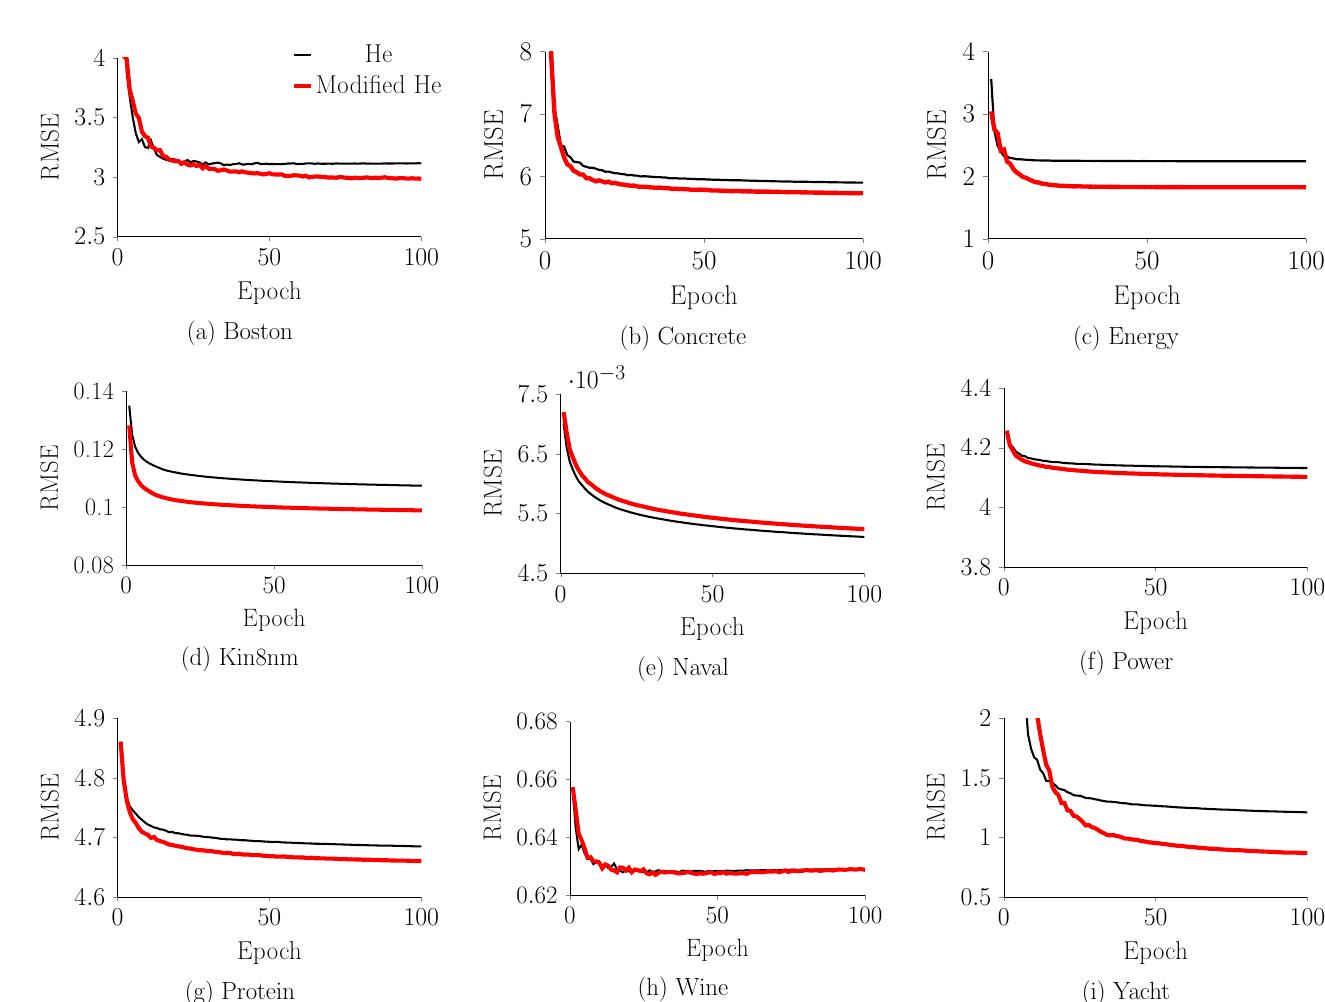

In [24]:
plt_img_base64(docs[1])
# plt_img_base64(docs[0])

## Evaluation using DeepEval

In [ ]:
%pip install -q deepeval 

In [38]:
from deepeval.metrics import FaithfulnessMetric, ContextualRelevancyMetric
from deepeval.test_case import LLMTestCase     
from deepeval import evaluate

In [39]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [42]:
query = "How is the performance of He compared to modified He for the various datasets such as Boston, Concrete etc.?"
retrieval_context = retriever_multi_vector_img.invoke(query, limit=6)

# print(retrieval_context)

actual_output = chain_mm_rag(query)


In [43]:
metric = FaithfulnessMetric(
    threshold=0.7,
    model="gpt-4o",
    include_reason=True
)
test_case = LLMTestCase(
    input=query,
    actual_output=actual_output,
    retrieval_context=retrieval_context
)

metric.measure(test_case)
print(metric.score)
print(metric.reason)

# or evaluate test cases in bulk
evaluate([test_case], [metric])

Event loop is already running. Applying nest_asyncio patch to allow async execution...

1.0
The score is 1.00 because there are no contradictions. Great job on ensuring complete alignment with the retrieval context!
Evaluating test cases...
Event loop is already running. Applying nest_asyncio patch to allow async execution...




Metrics Summary

  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions. Great job staying faithful to the retrieval context!, error: None)

For test case:

  - input: How is the performance of He compared to modified He for the various datasets such as Boston, Concrete etc.?
  - actual output: To compare the performance of He and Modified He across various datasets such as Boston, Concrete, etc., we can analyze the provided graphs that show the performance metrics over epochs for each dataset.

### Performance Comparison:

1. **Boston Dataset:**
   - **He:** The performance metric starts around 0.14 and decreases to approximately 0.08 by the 100th epoch.
   - **Modified He:** The performance metric starts around 0.12 and decreases to approximately 0.06 by the 100th epoch.
   - **Observation:** Modified He shows a better performance as it achieves a lower value faster and maintains it.

2.

✅ Tests finished! Run "deepeval login" to view evaluation results on the web.

[TestResult(success=True, metrics_metadata=[MetricMetadata(metric='Faithfulness', threshold=0.7, success=True, score=1.0, reason='The score is 1.00 because there are no contradictions. Great job staying faithful to the retrieval context!', strict_mode=False, evaluation_model='gpt-4o', error=None, evaluation_cost=0.03259, verbose_logs='Truths:\n[]\n\nClaims:\n[\n    "To compare the performance of He and Modified He across various datasets such as Boston, Concrete, etc., we can analyze the provided graphs that show the performance metrics over epochs for each dataset.",\n    "For the Boston Dataset, He starts around 0.14 and decreases to approximately 0.08 by the 100th epoch.",\n    "For the Boston Dataset, Modified He starts around 0.12 and decreases to approximately 0.06 by the 100th epoch.",\n    "For the Boston Dataset, Modified He shows a better performance as it achieves a lower value faster and maintains it.",\n    "For the Concrete Dataset, He starts around 4.9 and decreases to a

In [58]:
from deepeval.metrics import FaithfulnessMetric, ContextualRelevancyMetric, AnswerRelevancyMetric, HallucinationMetric
from deepeval.test_case import LLMTestCase     
from deepeval import evaluate

## Metric Functions

class LLM_Metric:
    def __init__(self, query, retrieval_context, actual_output):
        self.query = query
        self.retrieval_context = retrieval_context
        self.actual_output = actual_output

    # Faithfulness
    def get_faithfulness_metric(self):
        metric = FaithfulnessMetric(
            threshold=0.7,
            model="gpt-4o",
            include_reason=True
        )
        test_case = LLMTestCase(
            input=self.query,
            actual_output=self.actual_output,
            retrieval_context=self.retrieval_context
        )

        metric.measure(test_case)
        return metric.score, metric.reason

    # Contextual Relevancy
    def get_contextual_relevancy_metric(self):
        metric = ContextualRelevancyMetric(
            threshold=0.7,
            model="gpt-4o",
            include_reason=True
        )
        test_case = LLMTestCase(
            input=self.query,
            actual_output=self.actual_output,
            retrieval_context=self.retrieval_context
        )
        
        metric.measure(test_case)
        return metric.score, metric.reason
    
    # Answer Relevancy
    def get_answer_relevancy_metric(self):
        metric = AnswerRelevancyMetric(
        threshold=0.7,
        model="gpt-4o",
        include_reason=True
        )
        test_case = LLMTestCase(
            input=self.query,
            actual_output=self.actual_output
        )
        metric.measure(test_case)
        return metric.score, metric.reason
    
    # Hallucination
    def get_hallucination_metric(self):
        metric = HallucinationMetric(threshold=0.5)
        test_case = LLMTestCase(
        input=self.query,
        actual_output=self.actual_output,
        context=self.retrieval_context  
        )
        metric.measure(test_case)
        return metric.score, metric.reason

In [46]:
# Create an instance of LLM_Metric
llm_metric = LLM_Metric(query, retrieval_context, actual_output)

# Get faithfulness metric
faith_score, faith_reason = llm_metric.get_faithfulness_metric()

# Get contextual relevancy metric
relevancy_score, relevancy_reason = llm_metric.get_contextual_relevancy_metric()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Event loop is already running. Applying nest_asyncio patch to allow async execution...

In [53]:
import pandas as pd

pd.DataFrame([faith_reason, relevancy_reason], index=['faithfulness','context_relevancy'])

,0
faithfulness,The score is 1.00 because there are no contrad...
context_relevancy,The score is 1.00 because the input is perfect...


In [59]:

# Create an instance of LLM_Metric
llm_metric = LLM_Metric(query, retrieval_context, actual_output)

# Get answer relevancy metric
answer_relevancy_score, answer_relevancy_reason = llm_metric.get_answer_relevancy_metric()

# Check Hallucination
hallucination_score, hallucination_reason = llm_metric.get_hallucination_metric()

print(f"answer relevancy score and reason: {answer_relevancy_score} because {answer_relevancy_reason}")

Event loop is already running. Applying nest_asyncio patch to allow async execution...

answer relevancy score and reason: 1.0 because The score is 1.00 because the answer perfectly addresses the question without any irrelevant statements. Great job!


## user interface with Gradio

In [94]:
def multi_modal_rag_chain(retriever, memory=None):
    """
    Multi-modal RAG chain
    """
    if memory is None:
        memory = ConversationBufferMemory(return_messages=True, memory_key="chat_history")
    
    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024)

    # RAG pipeline
    chain = (
        RunnableParallel(
            {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
            "chat_history": lambda x: memory.load_memory_variables({})["chat_history"]
        })
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [95]:
import gradio as gr

# Create RAG chain
def generate(query):
    chain_mm_rag = multi_modal_rag_chain(retriever=retriever_multi_vector_img) # retriever_multi_vector_img
    # docs = retriever_multi_vector_img.invoke(query, limit=6)
    output = chain_mm_rag.invoke(query)
    
    return output

demo = gr.Interface(
    fn=generate,
    inputs=gr.Textbox(label="Query"),
    outputs=gr.Textbox(label="Response"),
    title="Chat with my Article",
    description="Enter your question regarding my research article, TAGI-V.",
    allow_flagging="never"
)

# launch the demo
demo.launch() 








Exception in thread Thread-475 (run):
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/uvicorn/server.py", line 65, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/nest_asyncio.py", line 26, in run
    
  File "/Users/bhargobdeka/Desktop/Projects/RAG/venv/lib/python3.10/site-packages/nest_asyncio.py", line 40, in _get_e

KeyboardInterrupt: 